In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
matplotlib.use("Agg")
import matplotlib.animation as animation


###Clear this laterr...

/home/matyi/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
class petri():
    """make a function instead??"""
    def __init__(self, sector_width=10, sectorNr=5, height = 20):
        #row = np.array(np.logspace(0, concentration, num=width))
        
        #np.insert(row,0,0)
        edges = np.zeros(sector_width)
        #print (edges)
        for i in range(sectorNr):
            #print (i)
            edges  = np.append(edges, np.ones(sector_width)*10**i, 0)
        self.concentrationMap = np.tile(edges, (height,1))
        #print (edges)
    def printmap(self):

        print (self.concentrationMap)
        print (self.concentrationMap.shape)

In [16]:
class bacteria():
    
    def __init__(self,  petriDish, parent_strength=0.2,):
        
        ##Base attributes
        self.dish=petriDish
        self.shape= self.dish.concentrationMap.shape
        
        self.bacteriaMap = np.zeros(self.shape)
        self.ageMap = np.zeros(self.shape)
        self.bacteriaMap[:,0] = parent_strength
        self.ageMap[:,0] = 1
        
        ##Attributes for evolving
        self.mu=1
        self.sigma=0.08
        self.generation=0
        self.liveBacMask=np.zeros(self.shape)
        
        
        ##Attributes for pretty plotting
        self.norm = mpl.colors.LogNorm()
        self.colormap='Blues'
        
        ##Attributes for video making
        self.video=[]
        self.fig=plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1)
        Writer = animation.writers['ffmpeg']
        self.writer = Writer(fps=20, metadata=dict(artist='MatyasCzeman'), bitrate=3600)
        

        
    def showBacMap(self, cmap='Blues'):      

        self.colormap = plt.get_cmap(cmap)
        plt.pcolormesh(self.bacteriaMap, cmap=self.colormap, norm=self.norm)
        #plt.savefig('images/foo%d.png' %self.generation, bbox_inches='tight')
        
    def showAgeMap(self, cmap='hot'):

        plt.pcolormesh(self.ageMap, cmap=cmap)
        
    def spread (self):
        
        newMap = np.empty_like (self.bacteriaMap)
        newMap[:] = self.bacteriaMap
        for (x,y), element in np.ndenumerate(self.bacteriaMap):
            #print (x,y, element)
            if np.random.rand() > 0.55 and self.bacteriaMap[x,y] == 0 : #and self.bacteriaMap[x,y] > self.dish.concentrationMap[x,y]:
            # if square is not empty and resistance > concentration:
                try: 
                    if self.bacteriaMap[x-1,y] > self.dish.concentrationMap[x,y]:
                        newMap[x,y] = self.bacteriaMap[x-1,y]
                except: pass
                try: 
                    if self.bacteriaMap[x+1,y] > self.dish.concentrationMap[x,y]:
                        newMap[x,y] = self.bacteriaMap[x+1,y]
                except: pass
                try: 
                    if self.bacteriaMap[x,y+1] > self.dish.concentrationMap[x,y]:
                        pass
                        newMap[x,y] = self.bacteriaMap[x,y+1]
                except: pass
                try: 
                    if self.bacteriaMap[x,y-1] > self.dish.concentrationMap[x,y]:
                        newMap[x,y] = self.bacteriaMap[x,y-1]
                except: pass
                # I use try to eliminate index out of range errors at the edges
                
        self.bacteriaMap = newMap 
        self.checkStats()
        
        ##Save current status for saving it as a video later
        self.video.append((self.ax.pcolormesh(self.bacteriaMap,
                                         cmap=self.colormap, norm=self.norm),))
                
    def checkStats(self):
        """Counts new values for visualizaton after every spread() step"""
        newMap = np.empty_like (self.bacteriaMap)
        newMap[:] = self.bacteriaMap
        newMap[np.where(newMap == 0)] = np.nan
             
        maxval=np.nanmax(newMap)
        minval=np.nanmin(newMap)
        self.norm = mpl.colors.LogNorm(vmax=maxval, vmin=minval)
        self.mean = np.nanmean(newMap)

    def evolve(self):
        
        # mean and standard deviation
        mutationMap = np.random.normal(self.mu, self.sigma, self.shape)
        self.bacteriaMap = self.bacteriaMap * mutationMap
        self.generation+=1
        self.age()
        
    def age(self):
        
        #newMap  = np.empty_like (self.ageMap)
        #newMap[:] = self.ageMap
        for (x,y), element in np.ndenumerate(self.ageMap):
            if  self.bacteriaMap[x,y] != 0:
                self.ageMap[x,y] += 1
                
        deathMask=np.zeros(self.shape)
        deathMask[self.ageMap>0]   = 1   # at occupied square bacs should evolve
        deathMask[self.ageMap>100] = 0   # at old square bacs sould not evolve
        
        ### 1 where there's a living bacteria
        self.liveBacMask=deathMask
        
    def onlineSpreading(self, steps=100):
        
        figOnline,ax = plt.subplots()
        for f in range(steps):
            self.evolve()
            self.spread()
            ax.pcolormesh(self.bacteriaMap, cmap=self.colormap, norm=self.norm)
            figOnline.canvas.draw()
            time.sleep(0.3)
            
    def saveVideo(self):

        dpi = 80
        width = 16
        height = 9 ## res = dpi*width*height
        self.fig.set_size_inches(width, height, True)

        im_ani = animation.ArtistAnimation(self.fig, self.video, interval=500, repeat_delay=3000,
                                   blit=True)
        im_ani.save('simul%d.mp4' %self.generation, writer=self.writer, dpi=dpi)

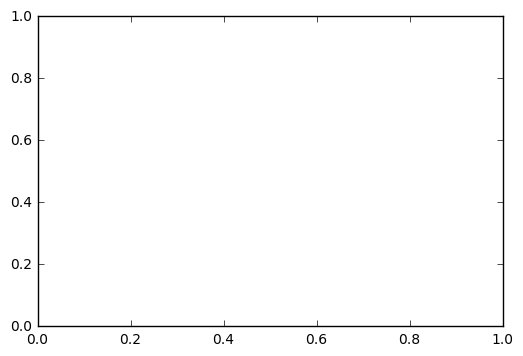

In [27]:
petriD = petri(10,4,40)
eColi=bacteria(petriD, 0.2)

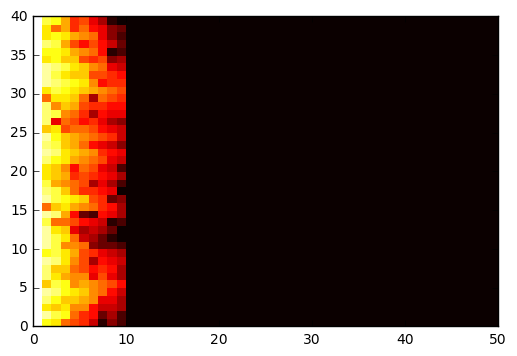

In [32]:
eColi.showAgeMap()

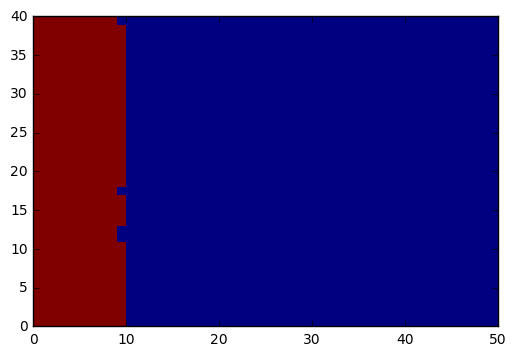

In [31]:
plt.pcolor(eColi.liveBacMask)

In [30]:
# while True:
simulStep=20

for i in range(simulStep):
   
    eColi.evolve()
    eColi.spread()

print ("Finished")


Finished


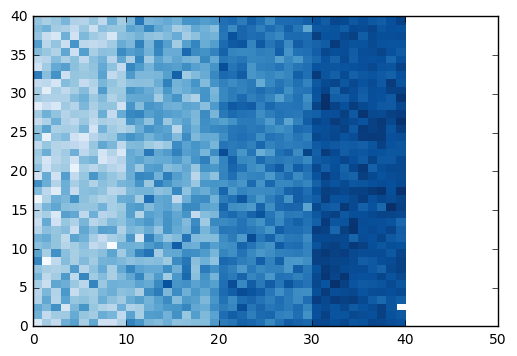

In [25]:
%matplotlib inline
eColi.showBacMap()

In [15]:
eColi.saveVideo()


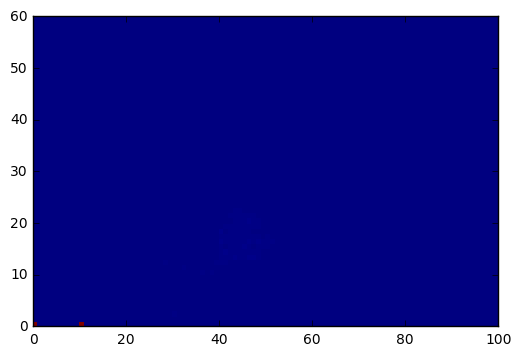

In [24]:
eColi.bacteriaMap[0,0]=2000
eColi.bacteriaMap[0,10]=2000
plt.pcolormesh(eColi.bacteriaMap)

<IPython.core.display.Javascript object>


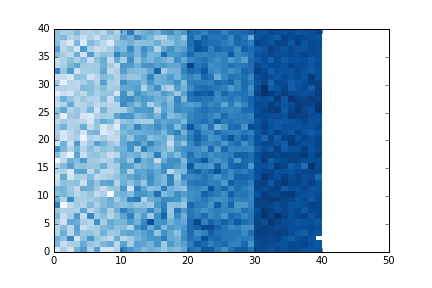

<IPython.core.display.Javascript object>


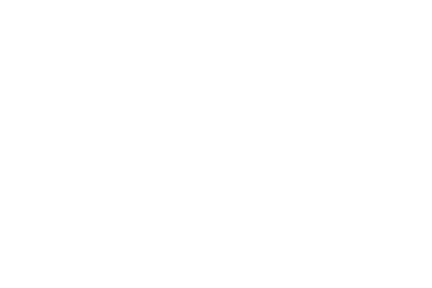

In [22]:
%matplotlib notebook
eColi.onlineSpreading(steps=200)

